In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../")
from utils import display_model

In [2]:
data_dir = "../../data/20231002_LCLS_Injector/"

vanilla_files = [
    "vanilla_optimization_2d_1.yml",
    "vanilla_optimization_9d_1_roi_adjusted.yml",
]

nn_files = [
    "nn_optimization_2d_1.yml",
    "nn_optimization_2d_2.yml",
    "nn_optimization_9d_1.yml",
    "nn_optimization_9d_2_roi_adjusted.yml",
    "nn_optimization_9d_3_roi_adjusted.yml",
    "nn_optimization_9d_4_prior_adjusted.yml",
    "nn_optimization_9d_5_prior_adjusted.yml",
    "nn_optimization_9d_6_low_reg_cal.yml",
]

files = vanilla_files + nn_files

In [3]:
def eval_beamsize(input_dict):
    pass

In [4]:
vanilla_xs = []
for file in vanilla_files:
    with open(data_dir + file) as f:
        X = Xopt.from_yaml(f)
    vanilla_xs.append(X)

nn_xs = []
for file in nn_files:
    with open(data_dir + file) as f:
        X = Xopt.from_yaml(f)
    nn_xs.append(X)

xs = vanilla_xs + nn_xs

## Load NN Prior Model

In [5]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        # return torch.sqrt(torch.abs(sigma_x) * torch.abs(sigma_y))
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y) + 100.0

In [6]:
model_path = "../lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}


def load_nn_prior(vocs):
    # create LUME-model
    lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn],
        output_transformers=[output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    lume_module = LUMEModule(
        model=lume_model,
        feature_order=list(vocs.variable_names),
        output_order=lume_model.outputs[0:2],
    )
    
    return ObjectiveModel(lume_module)

## Load Calibrated NN Prior Models

In [7]:
calibration_path = "../calibration/"

def load_cal_prior(vocs, reg="low"):
    
    # load nn_to_cal transformers
    input_nn_to_cal = torch.load(calibration_path + f"input_nn_to_cal_{reg}_reg.pt")
    output_nn_to_cal = torch.load(calibration_path + f"output_nn_to_cal_{reg}_reg.pt")
    
    # create LUME-model
    cal_lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
        output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    cal_lume_module = LUMEModule(
        model=cal_lume_model,
        feature_order=list(vocs.variable_names),
        output_order=cal_lume_model.outputs[0:2],
    )
    
    return ObjectiveModel(cal_lume_module)

## Negative Posterior Values

In [8]:
X = xs[-2]

<Axes: >

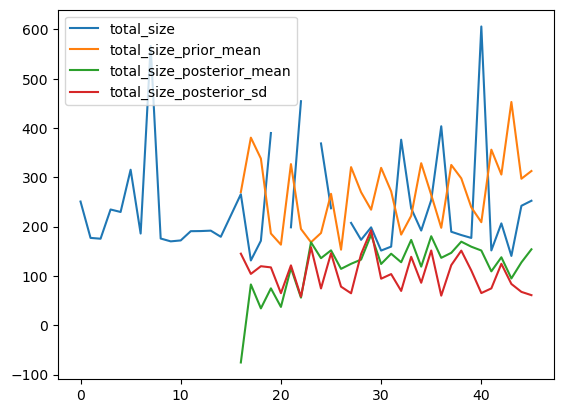

In [9]:
df = X.data
df.index = df.index.values.astype(int)
df = df.sort_index()
df[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot()

In [10]:
df.iloc[:16]["total_size_posterior_mean"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
16   -75.444337
Name: total_size_posterior_mean, dtype: float64

In [11]:
input_dict = df.iloc[15][X.vocs.variable_names].to_dict()
input_dict

{'QUAD:IN20:121:BCTRL': -0.0080117277,
 'QUAD:IN20:122:BCTRL': -0.0122183569,
 'QUAD:IN20:361:BCTRL': -3.4093373716,
 'QUAD:IN20:371:BCTRL': 2.5430055688,
 'QUAD:IN20:425:BCTRL': -1.7484424431,
 'QUAD:IN20:441:BCTRL': -0.6603721661,
 'QUAD:IN20:511:BCTRL': 3.8420324658,
 'QUAD:IN20:525:BCTRL': -2.3241027943,
 'SOLN:IN20:121:BCTRL': 0.4733820162}

In [12]:
input_tensor = torch.tensor([v for k, v in input_dict.items()]).unsqueeze(0)
nn_prior = load_nn_prior(X.vocs)
output_tensor = nn_prior(input_tensor)
output_tensor

tensor(270.0682, dtype=torch.float64)

In [13]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

from gpytorch.means import ConstantMean


# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": load_nn_prior(X.vocs)},
)
generator = ExpectedImprovementGenerator(
    vocs=X.vocs,
    model_constructor=model_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": None})
X_new = Xopt(generator=generator, evaluator=evaluator, vocs=X.vocs)
X_new.evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": X_new.generator})

In [14]:
X_new.add_data(df.iloc[:15])

In [15]:
X_new.data["total_size_posterior_mean"]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
Name: total_size_posterior_mean, dtype: float64

In [16]:
_ = X_new.generator.train_model(X_new.data)

In [17]:
def get_model_predictions(input_dict, generator = None):
    output_dict = {}
    for output_name in generator.vocs.output_names:
        if generator is not None and generator.model is not None:
            gp = generator.model.models[generator.vocs.output_names.index(output_name)]
            x = torch.tensor([input_dict[k] for k in generator.vocs.variable_names], dtype=torch.double).unsqueeze(0)
            with torch.no_grad():
                _x = gp.input_transform.transform(x)
                _x = gp.mean_module(_x)
                prior_mean = gp.outcome_transform.untransform(_x)[0].item()
                posterior = gp.posterior(x)
                posterior_mean = posterior.mean.item()
                posterior_sd = torch.sqrt(posterior.mvn.variance).item()
        else:
            prior_mean, posterior_mean, posterior_sd = np.nan, np.nan, np.nan
    
        output_dict[output_name + "_prior_mean"] = prior_mean
        output_dict[output_name + "_posterior_mean"] = posterior_mean
        output_dict[output_name + "_posterior_sd"] = posterior_sd
    return output_dict

In [18]:
get_model_predictions(input_dict, X_new.generator)["total_size_posterior_mean"]

-72.29908382510857

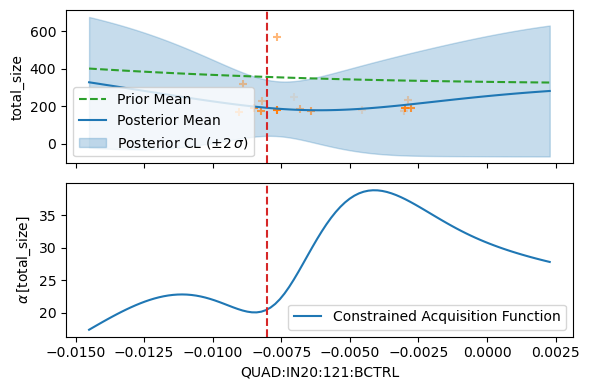

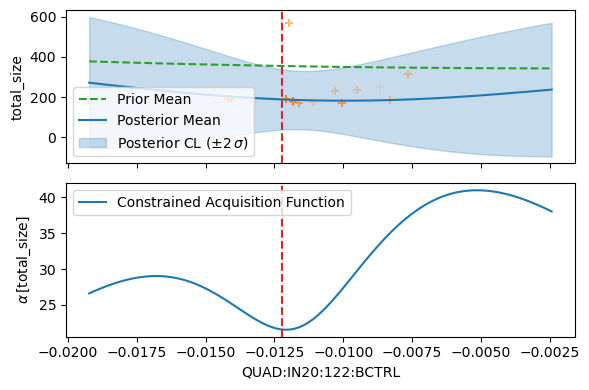

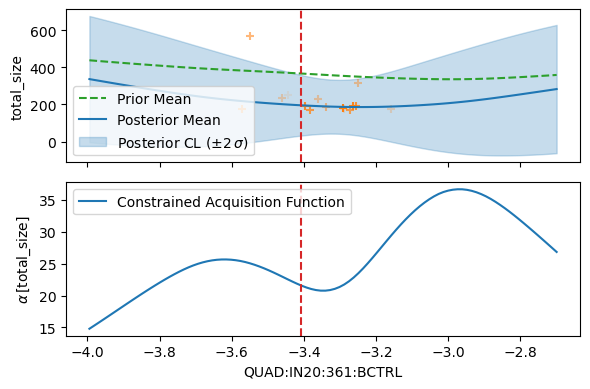

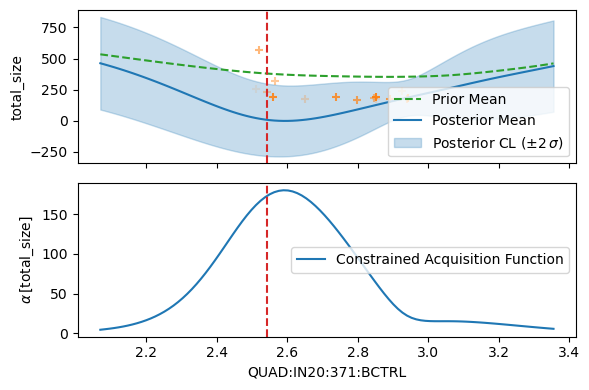

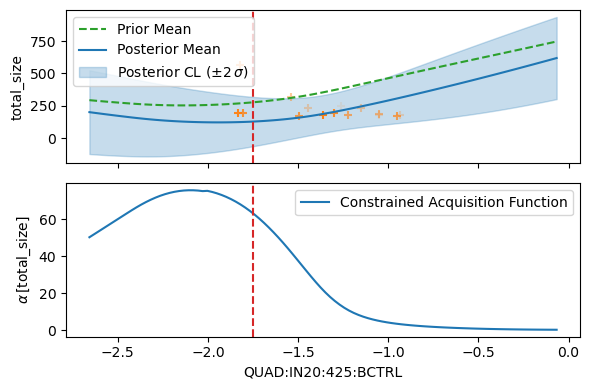

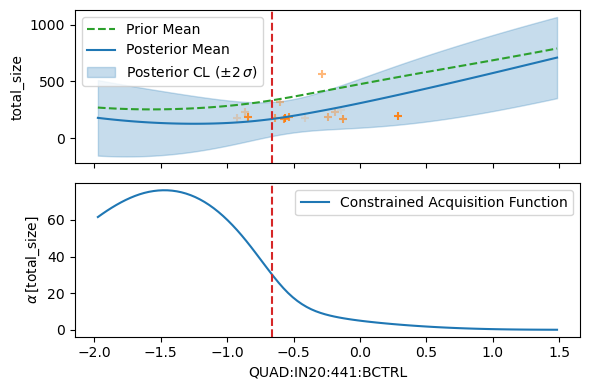

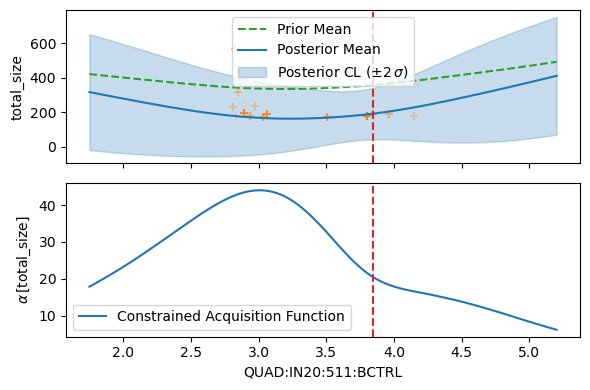

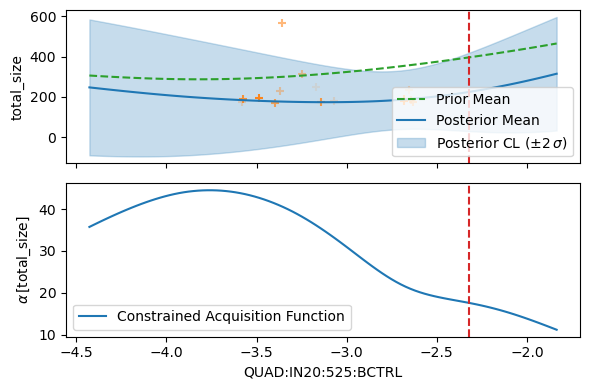

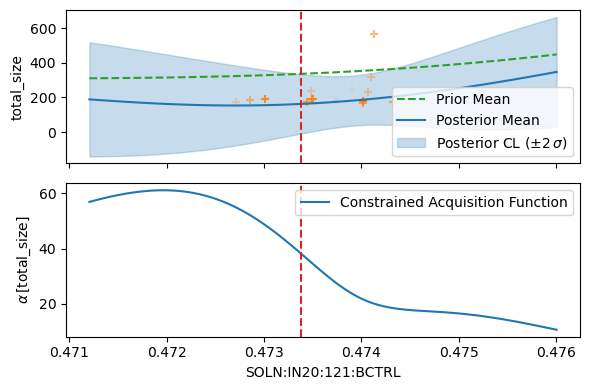

In [20]:
n_grid = 100

for name in X_new.vocs.variable_names:
    fig, ax = display_model(
        X=X_new,
        variable_names=[name],
        n_grid=n_grid,
    )
    new_sample = input_dict[name]
    for ax_i in ax.flatten():
        ax_i.axvline(x=new_sample, linestyle="--", c="C3")
    fig.tight_layout()

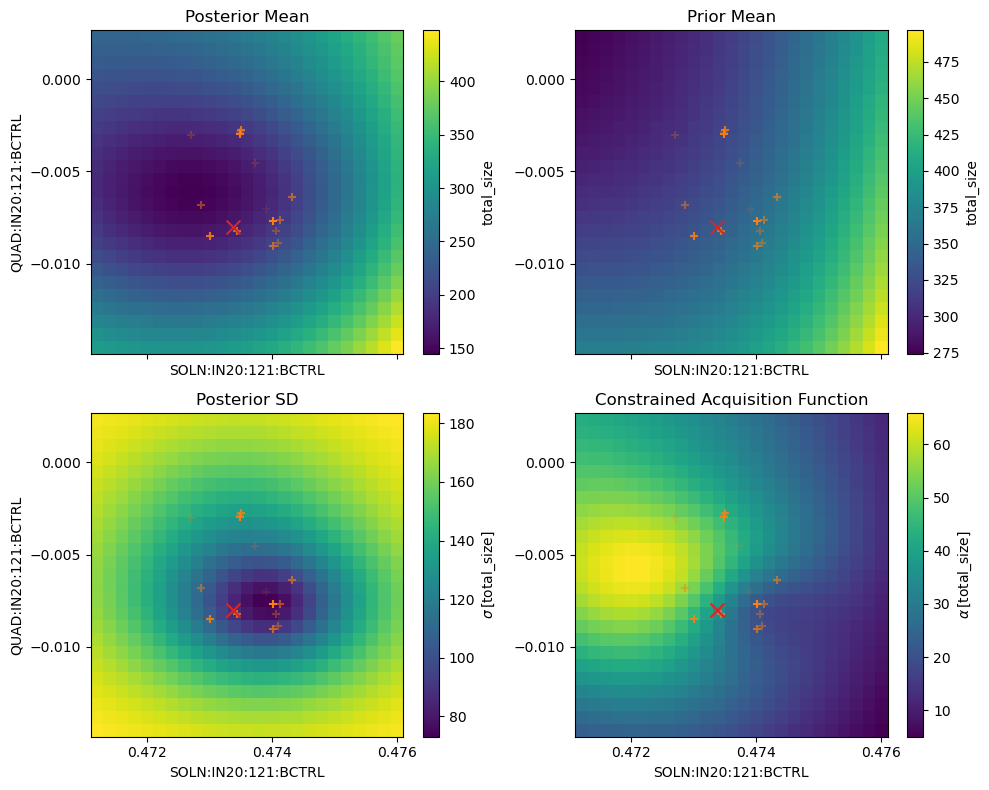

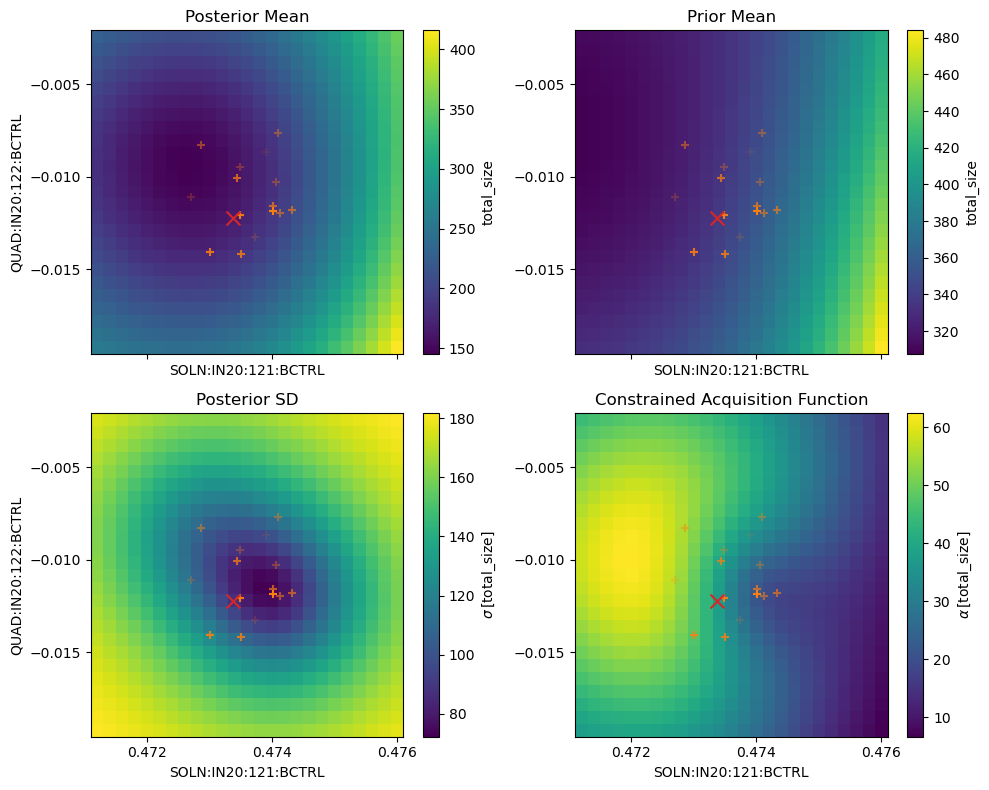

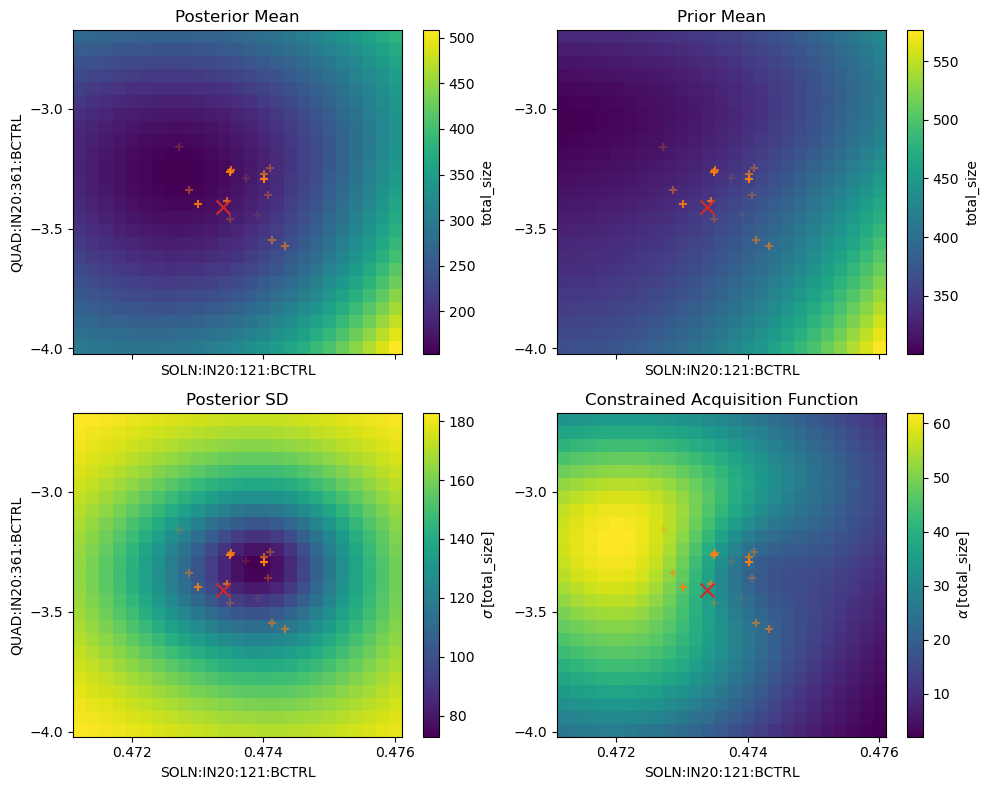

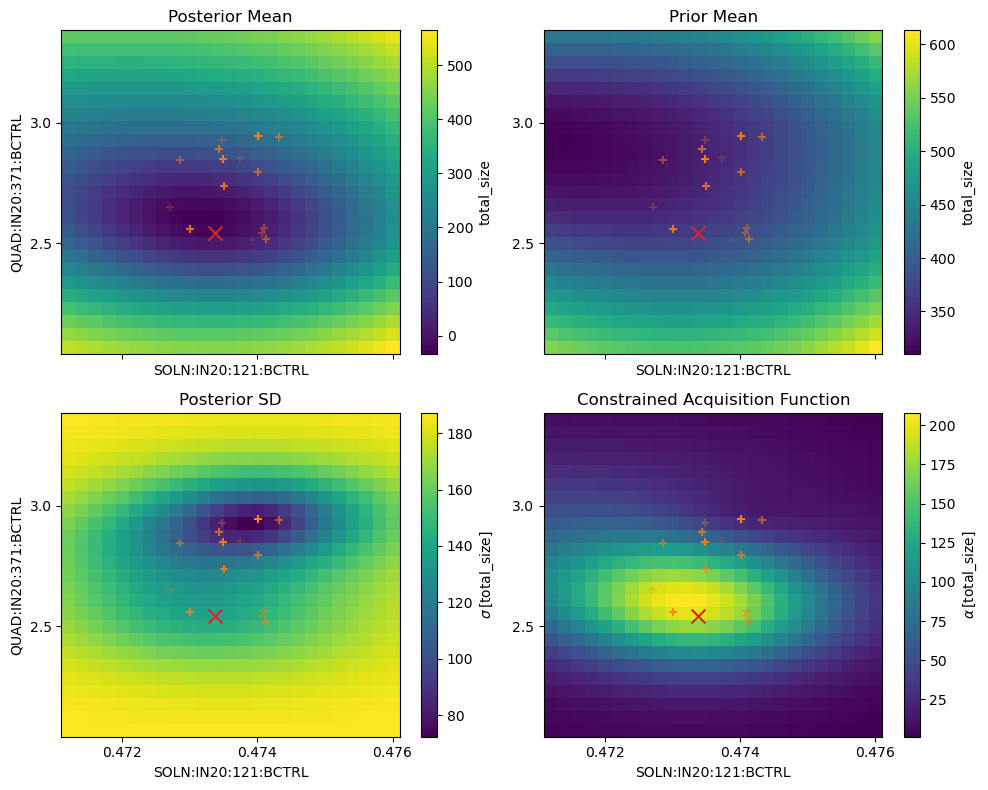

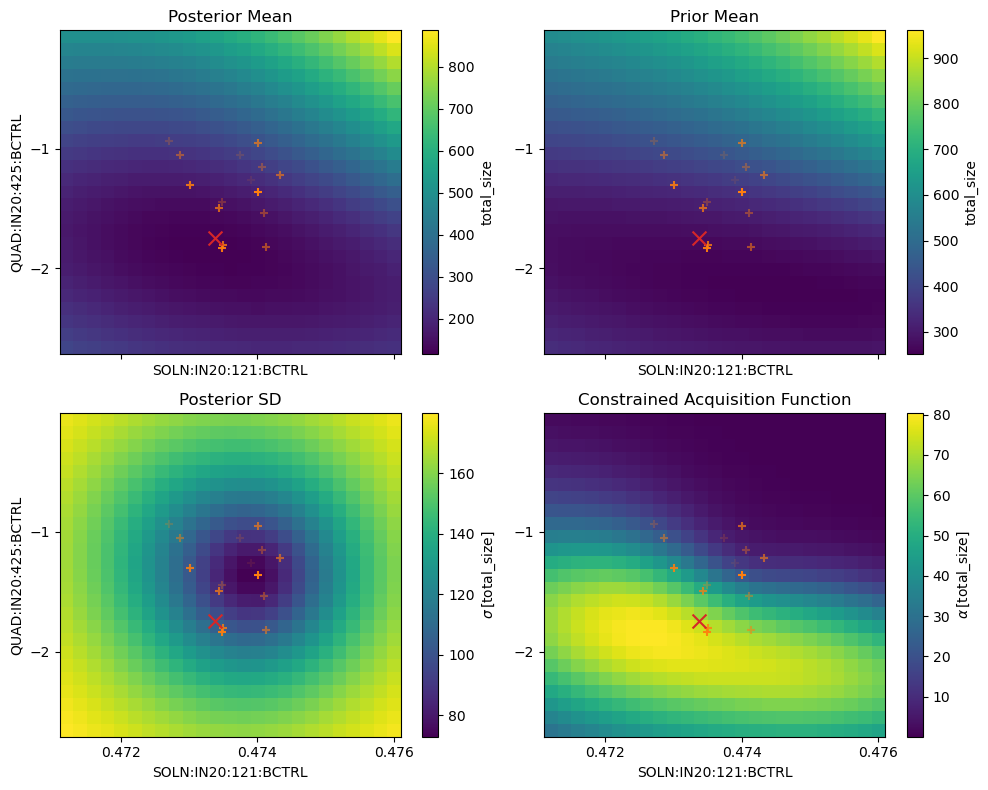

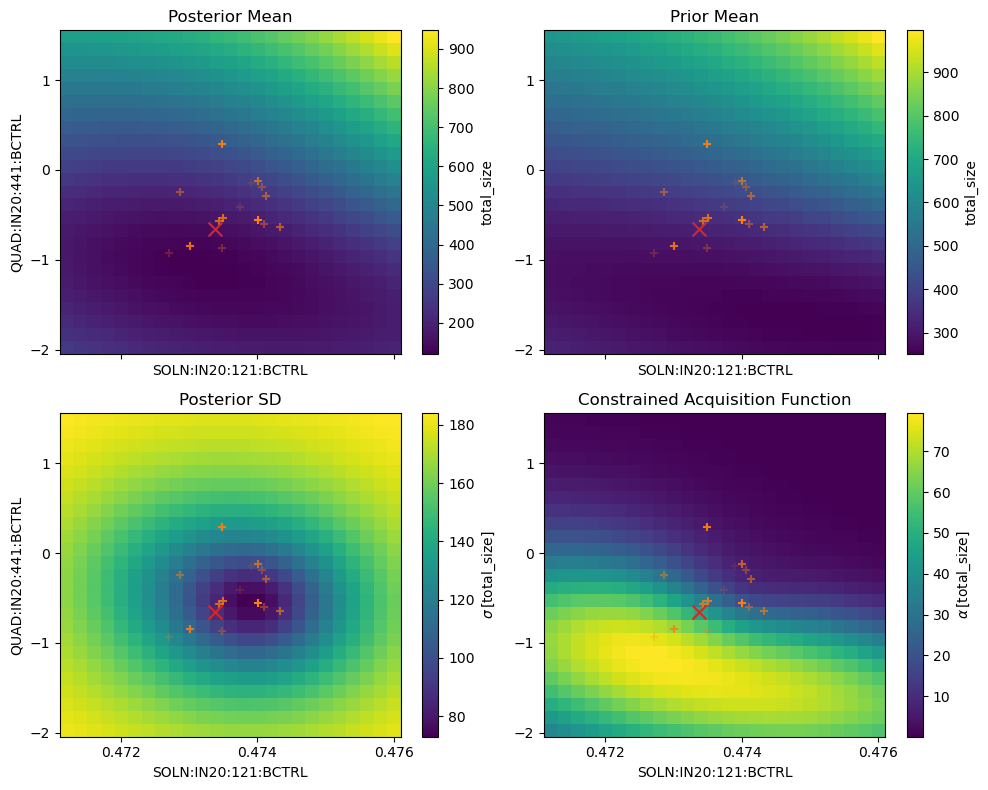

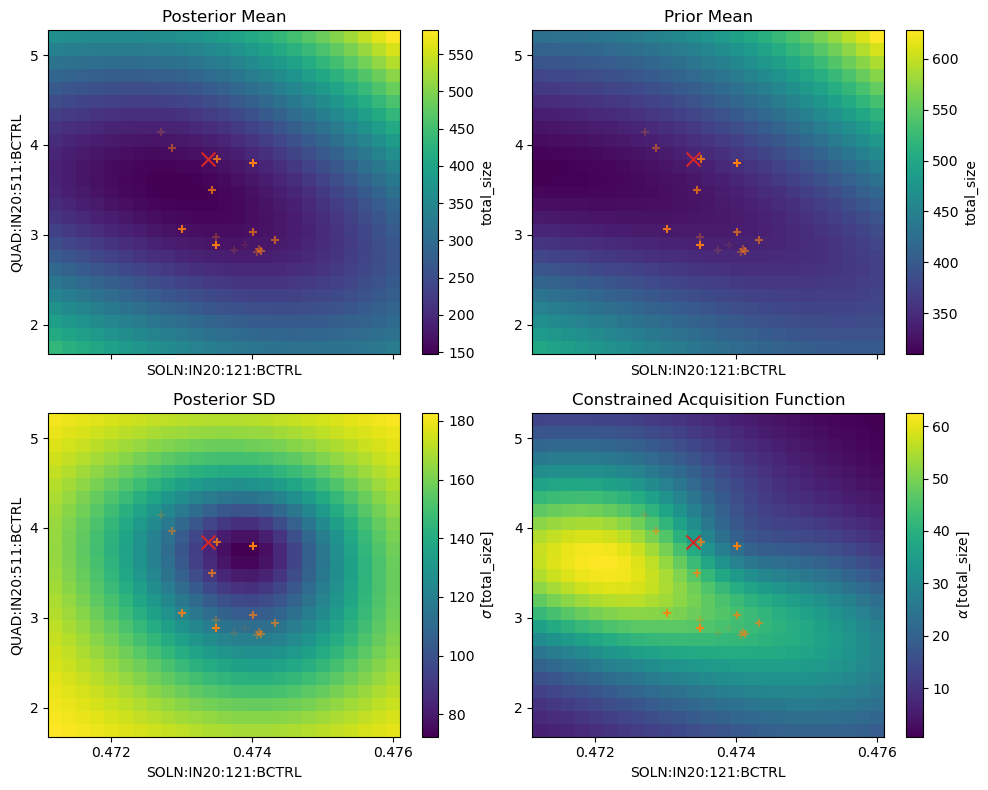

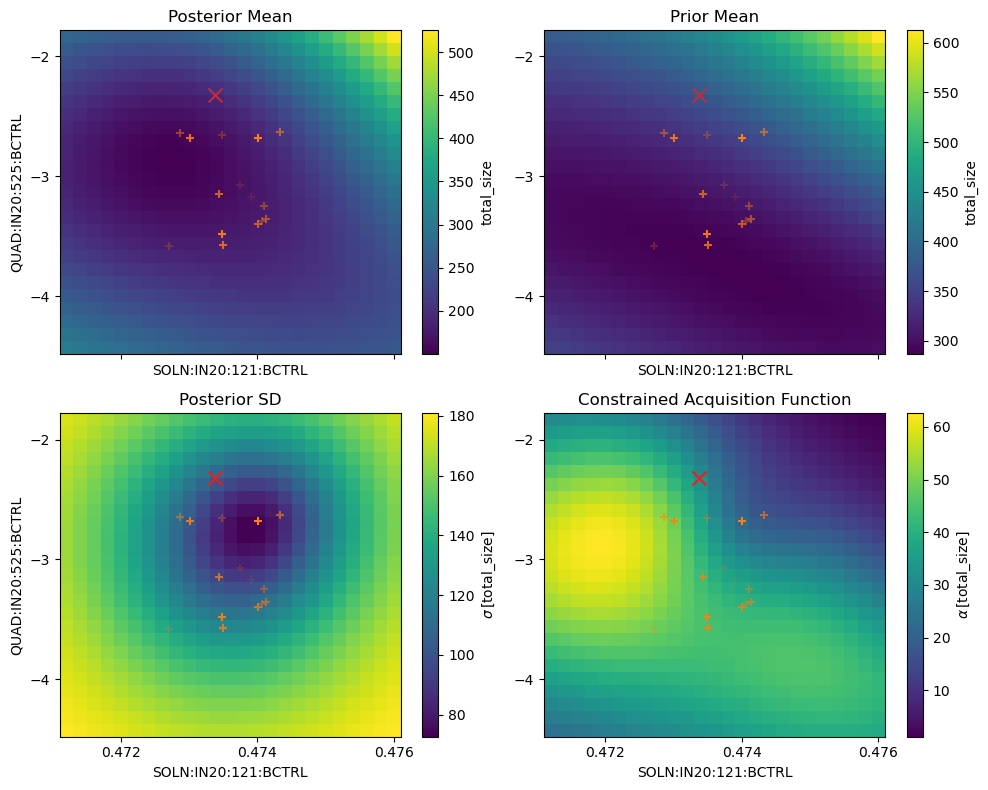

In [21]:
n_grid = 25

for name in X_new.vocs.variable_names:
    if not name == "SOLN:IN20:121:BCTRL":
        variable_names=["SOLN:IN20:121:BCTRL", name]

        fig, ax = display_model(
            X=X_new,
            variable_names=variable_names,
            constrained_acqf=True,
            n_grid=n_grid,
        )
        new_sample = [input_dict[k] for k in variable_names]
        for ax_i in ax.flatten():
            ax_i.scatter(*new_sample, marker="x", s=100, c="C3")
        fig.tight_layout()

In [35]:
var_names, ls = [], []
gp = X_new.generator.model.models[X_new.generator.vocs.output_names.index("total_size")]
for i, name in enumerate(X_new.vocs.variable_names):
    var_names.append(name)
    ls.append(gp.covar_module.base_kernel.lengthscale[0, i].item())
lengthscales = pd.DataFrame({"Lengthscale": ls}, index=var_names)
lengthscales

,Lengthscale
QUAD:IN20:121:BCTRL,0.309559
QUAD:IN20:122:BCTRL,0.426401
QUAD:IN20:361:BCTRL,0.373346
QUAD:IN20:371:BCTRL,0.190212
QUAD:IN20:425:BCTRL,0.483331
QUAD:IN20:441:BCTRL,0.375281
QUAD:IN20:511:BCTRL,0.343604
QUAD:IN20:525:BCTRL,0.458992
SOLN:IN20:121:BCTRL,0.441581
